In [2]:
#Load libraries, etc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
!pip install opencv-python
import cv2
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

# CHEM E 498: Final Exam

## Due  06/05 at 5:00 pm

### Note: This is an exam and should represent only your work. Carefully following the code of conduct is critical.

<b>Broad overview of the problem</b> : In this exam, you are using an Infrared (IR) Spectroscopic Imaging data of a patient sample taken by me in the lab. This dataset is a multidimensional data, with x and y positions capturing the spatial coordinates of points on the image and z positions recording the absorption of light at different frequencies in the mid-infrared region of the light. You have two more images supplementing the IR data where the classified image is showing three different cell types in the sample (one in green, one in blue, one in magenta). The green cells are where cancer originates and is also known as epithelial cells, magenta is the one where there are collagen fibers and blue cells are all other cells combined together. The H&E image is the image we get from clinicians that is typically used in hospitals to make a cancer diagnosis. I wanted to give you all an experience to implement the course knowledge on a real dataset with potential human impact. In the homework 4, you implemented unsupervised learning techniques and in the final exam you will apply supervised techniques along with dimensionality reduction. Good Luck! 

#### General Instructions: you should run every cell of your jupyter notebook and then submit the jupyter notebook so that I can see the output without initially running it. The notebook name should your name. Every graph/plot should be labeled. The code should have comments so that it is easy to follow through what you have done. All the text components should be present as markdown cells in the same jupyter notebook. Wherever a random state needs to be defined to have consistent output across multiple runs, use a random state of 40.  No late submissions will be graded

In [3]:
!pip install spectral
import spectral as spy
from spectral import *
data_object = spy.envi.open('43948_set1_inv_mnf_subset.hdr', '43948_set1_inv_mnf_subset')
#load data
dataIR = data_object.load() # using the load function to actually read the data
X = dataIR.reshape(dataIR.shape[0]*dataIR.shape[1], -1)

In [4]:
# preprocessing the data 
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df_standard=X.copy()
scaled_df_standard=pd.DataFrame(scaler.fit_transform(scaled_df_standard), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])

In [5]:
# reading the labeled data 
import imageio.v2 as iio
 
# read an image
img = iio.imread("classified_image-2.tiff")
# epi = [0,255,0]
# stroma = [128,0,230]
# others = [0,0,255]

In [6]:
img_rgb = img[:,:,:3]

In [7]:
target = img_rgb.reshape(img_rgb.shape[0]*img_rgb.shape[1],3) #reshaping the image data to a 2D array 
#creating the labeled vector
target_new = np.zeros(len(target))
for i in range(len(target)):
    if target[i,0] ==0 & target[i,1] ==255:
        target_new[i] = 0
    elif target[i,2] ==255:
        target_new[i] = 2
    elif target[i,0] ==128:
        target_new[i] = 1

In [8]:
#finding the pixels where the color value is not black
sum_matrix=np.sum(target, axis=1)
ind = np.where(sum_matrix!=0)

In [9]:
# only keeping the non-black pixels
dataIR2=X[ind[0],:]
# finding the subset of labels 
target_final = target_new[ind[0]]
dataIR2.shape

(1021488, 11)

In [10]:
#Apply Preprocessing
scaler = StandardScaler()
scaled_df_standard2=dataIR2.copy()
scaled_df_standard2=pd.DataFrame(scaler.fit_transform(scaled_df_standard2), columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])

#### Question1: Plot the non-background pixels (preprocessed data) as a scatter plot of feature 1 vs feature 2 while using the labels to color the observations. Next, theoretically discuss which of the following models [LDA, SVM (linear), SVM (kernel based), Decision Trees and RF] will work better than the others in the list.  (7 points)

Text(0, 0.5, 'PC2')

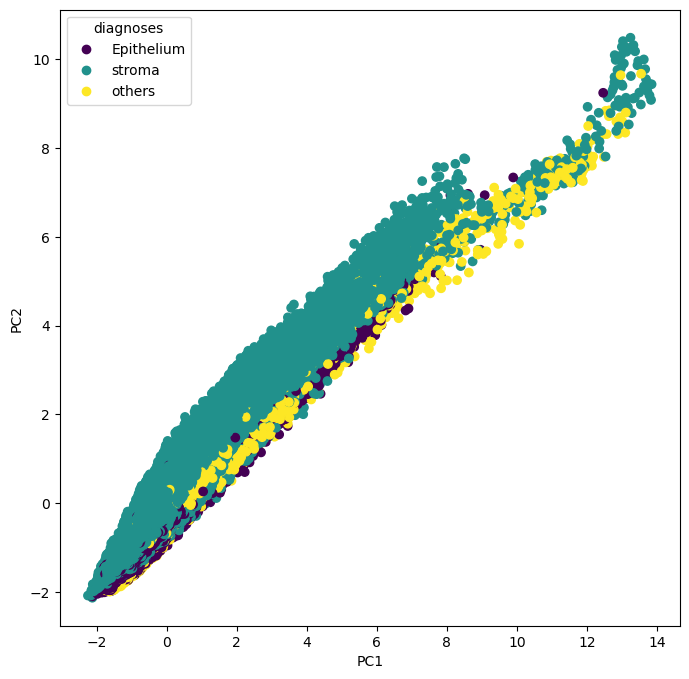

In [11]:
# plotting the first two components of the PCA
plt.figure(figsize=(8,8))
scatter=plt.scatter(scaled_df_standard2.iloc[:,0],scaled_df_standard2.iloc[:,1],c=target_final)
plt.legend(handles=scatter.legend_elements()[0], labels=['Epithelium','stroma','others'], title="diagnoses")
plt.xlabel("PC1")
plt.ylabel("PC2")

##### Discussion

I think SVM (kernel) will perform the best, followed by SVM (linear) amd Random Forest. I don't think LDA or Decision Trees will perform well. I think thos because we have high dimensional data with non-linear boundaries, which suits SVM (kernel) well. I think the lack of defined, linear boundaries and noisy data will hurt SVM (linear) and Random Forests and will make them perform worse. I think the depth of the decision tree and data overlap will hurt LDA and Decision trees methods

#### Question 2: Split your data (preprocessed data with no background pixels) into train and test with 1% of your data going to test. Remove the outliers from the training data based on z-score value of 3. Next, out of the resulting training data, sample only 1% to fit the classification algorithms. Implement [LDA, SVM (linear), SVM (kernel based, rbf), Decision Trees and RF] on this data and output the train and test accuracies ( 8 points). 

In [12]:
#Split into train and test
X_train, X_test , y_train, y_test = train_test_split(scaled_df_standard2, target_final, test_size=0.01,random_state=40)

In [13]:
#calculating z-score
z = np.abs(stats.zscore(X_train))
#setting z-score threshold
threshold = 3
# removing the outliers
list_remove = np.where(z>threshold)
#Create new dataframe
X_train_no_out = X_train.drop(pd.DataFrame(list_remove[0]))
Y_train_no_out = pd.DataFrame(y_train).drop(list_remove[0])

In [14]:
X_train_sampled = X_train_no_out.sample(frac =.01,random_state=40)
Y_train_sampled = np.ravel(pd.DataFrame(y_train).sample(frac =.01,random_state=40))

##### LDA

In [15]:
# implmenting LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
#create linear discriminant model object
lda = LDA()
#train classifier
lda.fit(X_train_sampled, Y_train_sampled)
print('LDA Accuracy = %.2f%%' % (accuracy_score(y_test, lda.predict(X_test)) * 100))

LDA Accuracy = 75.46%


##### SVM (Linear)

In [16]:
from sklearn.svm import LinearSVC
model = LinearSVC(dual="auto")
clf_svm = model.fit(X_train_sampled, Y_train_sampled)
print("Linear SVM accuracy on training set: {:.3f}".format(clf_svm.score(X_train_sampled, Y_train_sampled)))
print("Linear SVM accuracy on test set: {:.3f}".format(clf_svm.score(X_test, y_test)))

Linear SVM accuracy on training set: 0.757
Linear SVM accuracy on test set: 0.755


##### SVM (RBF)

In [17]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X_train_sampled, Y_train_sampled)
#extracting the support vectors 
sv = svm.support_vectors_
#the right hand side gives the decision function
sv_labels = svm.dual_coef_.ravel() > 0
print("Accuracy on training set: {:.3f}".format(svm.score(X_train_sampled, Y_train_sampled)))
print("Accuracy on test set: {:.3f}".format(svm.score(X_test, y_test)))

Accuracy on training set: 0.758
Accuracy on test set: 0.754


##### Decision Trees

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=40)
clf.fit(X_train_sampled, Y_train_sampled)
print("Decision Trees accuracy on training set: {:.3f}".format(clf.score(X_train_sampled, Y_train_sampled)))
print("Decision Trees accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))

Decision Trees accuracy on training set: 1.000
Decision Trees accuracy on test set: 0.601


##### Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=40)
clf_rf.fit(X_train_sampled, Y_train_sampled)
print("Random Forest accuracy on training set: {:.3f}".format(clf_rf.score(X_train_sampled, Y_train_sampled)))
print("Random Forest accuracy on test set: {:.3f}".format(clf_rf.score(X_test, y_test)))

Random Forest accuracy on training set: 1.000
Random Forest accuracy on test set: 0.747


#### Question 3: Identify the top features from the RF model built in Q2. based on feature importance. Use these two features to build a new RF model and optimize it by tuning the following hyperparameters (number of trees, maximum depth and minimum samples at the leaf node). Discuss how the choice of hyperparameters is affecting the accuracy of your model and output the train and test accuracies from your best model (15 points). 

In [20]:
# Get feature importances
feature_importances = clf_rf.feature_importances_

# Sort feature importances from highest to lowest
sorted_importances = np.argsort(feature_importances)[::-1]
print("Features sorted by importance:")
print(sorted_importances)

Features sorted by importance:
[ 0  1  6 10  2  5  4  7  8  3  9]


In [21]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_leaf': [1, 2, 3, 4],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [22]:
# Fit the grid search to the data
grid_search.fit(X_train_sampled.iloc[:, sorted_importances[:2]], Y_train_sampled)
grid_search.best_params_

Fitting 3 folds for each of 80 candidates, totalling 240 fits


{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}

In [23]:
best_grid = grid_search.best_estimator_
print("Random Forest accuracy on training set: {:.3f}".format(best_grid.score(X_train.iloc[:, sorted_importances[:2]], y_train)))
print("Random Forest accuracy on test set: {:.3f}".format(best_grid.score(X_test.iloc[:, sorted_importances[:2]], y_test)))

Random Forest accuracy on training set: 0.757
Random Forest accuracy on test set: 0.754


##### Discussion

###### Given the similarity of the accuracy of the rf model on the training and test sets, we can state that the best model is 
###### not overfitted. The best parameters attained by the grid search indicate that a low maximum tree depth is best, a higher
###### proportion of the features sampled, and a large amount of estimators. Deeper trees were likely overfitted to the training 
###### data, where 10 was our smallest value. It likely benefitted the trees to use four features at each juncture as it may 
###### have allowed to it to give more weight to the most important feature(s). Using the most estimators we tested for likely 
###### resulted in the best results as it provided a good amount of complexity without overfitting to the data. 

#### Question 4: Dimensionality Reduction: Apply PCA to your data (as used in Q2.) with a total of two components. Use these components as features in your best model from Q3. Discuss the performance after PCA by looking the test accuracies and the confusion matrices. (10 points)

##### PCA

Random Forest accuracy on PCA training set: 0.759
Random Forest accuracy on PCA test set: 0.754


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


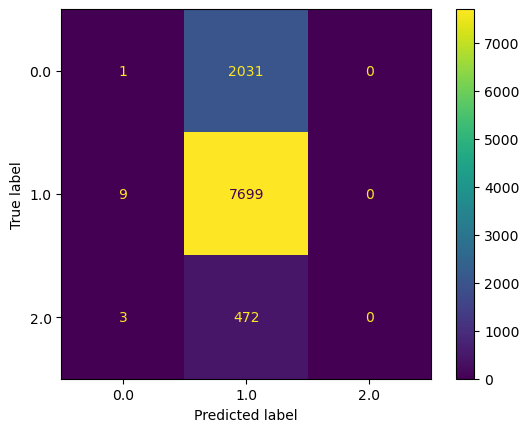

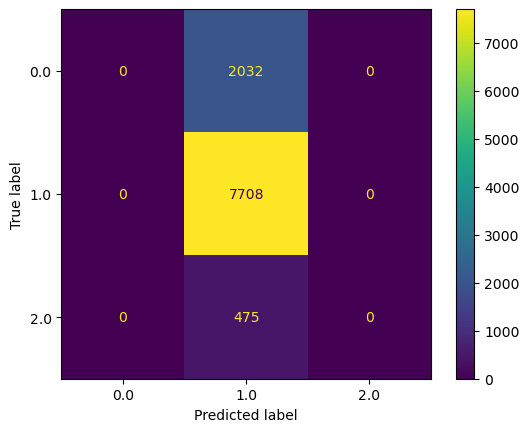

[CV] END max_depth=None, min_samples_leaf=1, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=150; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=150; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=None, min_samples_leaf=3, n_estimators=150; total time=   2.5s
[CV] END max_depth=None, min_samples_leaf=4, n_estimators=50; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=4, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=4, n_estimators=100; total time=   1.5s
[CV] END max_depth=No

In [25]:
# PCA object with a total of two components
pca = PCA(n_components = 2)
#fit PCA to sampled portion of the scaled data, as done in Q2. Transform both portions of the data.
X_train_pca = pca.fit_transform(X_train_sampled)
X_test_pca = pca.transform(X_test)

new_best = best_grid
new_best.fit(X_train_pca, Y_train_sampled)
print("Random Forest accuracy on PCA training set: {:.3f}".format(new_best.score(X_train_pca, Y_train_sampled)))
print("Random Forest accuracy on PCA test set: {:.3f}".format(best_grid.score(X_test_pca, y_test)))

best_predictions = new_best.predict(X_test_pca)
ConfusionMatrixDisplay.from_predictions(y_test, best_predictions)
grid_predictions = best_grid.predict(X_test.iloc[:, sorted_importances[:2]])
ConfusionMatrixDisplay.from_predictions(y_test, grid_predictions)

In [ ]:
##### Discussion

In [ ]:
###### Random forest accuracy is roughly equal to the other sorting methods performed in question 2,
###### matching SVM most in terms of accuracy, slightly increasing the accuracy of random forest testing
###### in question 3, and greatly reducing the overfitting from the random forest in question 2.